Primeiramente, importe as bibliotecas principais

In [1]:
import numpy as np
import control as ct
from control.matlab import *
import matplotlib as mpl
import matplotlib.pyplot as plt

import sympy as sym
from sympy.physics.control.control_plots import bode_plot

Nos exemplos abaixo, uma planta simples representada por H(s) será regulada por um controlador do tipo PI(s), dados por:

$$H(s) = \frac{k_0}{1+\tau s}$$

$$PI(s) = K\cdot \left[1+\frac{1}{s\cdot T_i}\right]$$ 

### Manipulação numérica

As funções presentes na biblioteca [control.matlab](https://python-control.readthedocs.io/en/0.9.4/conventions.html) possuem sintaxe similar à das funções de controle mais utilizadas do Matlab.

A definição das funções de transferência pode ser feita diretamente com a variável 's' utilizando o comando 'tf':

In [2]:
s = ct.tf('s')

# Dados da planta
k_0 = 100
tau = 0.01

H = k_0 / (1 + tau*s)

# Dados do controlador
K = 1
Ti = 1

PI = K * (1 + 1/s/Ti)

print('H =',H)
print('PI =', PI)

H = <TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   100
----------
0.01 s + 1

PI = <TransferFunction>: sys[13]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s + 1
-----
  s



Para obter sua resposta em frequência, pode-se utilizar a função 'bode':

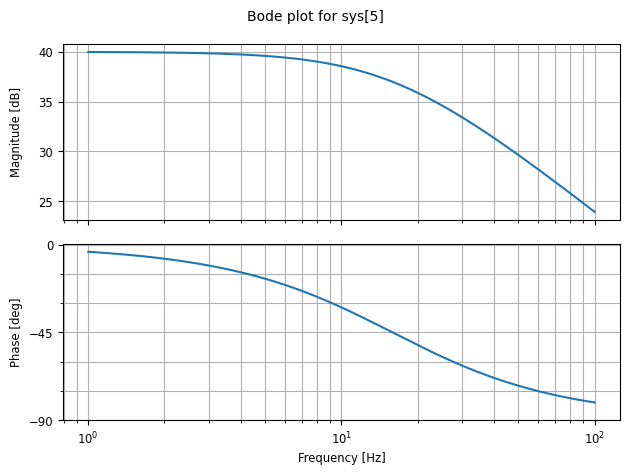

In [3]:
mag_H, phase_H = ct.bode(H, Hz=True)

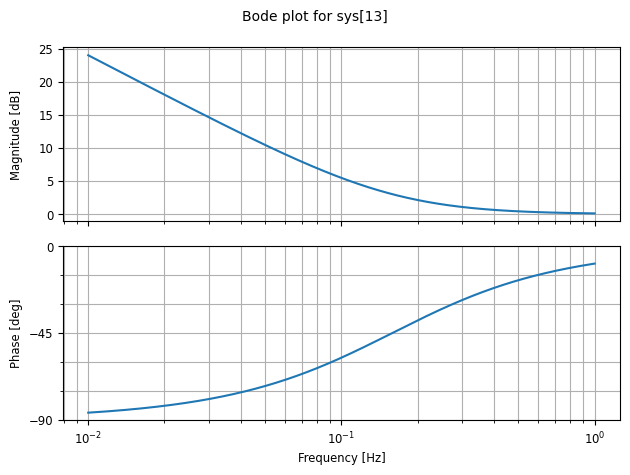

In [4]:
mag_PI, phase_PI = ct.bode(PI, Hz=True)

Se não for necessário plotar a imagem, pode-se inserir um parâmetro adicional 'plot=False'.

Caso necessário, pode-se especificar o vetor de frequências ao longo do qual a resposta é calculada a partir de um parâmetro 'omega'. Isto é especialmente útil para o cálculo de controladores, uma vez que a magnitude e a fase do sistema precisa ser conhecida para uma frequência específica.

Por exemplo, para obtenção da magnitude e da fase em 100Hz, pode-se fazer:

In [5]:
mag_100Hz, phase_100Hz, omega_100Hz = ct.bode(H, omega=2*np.pi*100, plot=False)

print('Magnitude at', omega_100Hz[0]/2/np.pi, 'Hz:', mag_100Hz[0], '(linear, not dB)')
print('Phase at', omega_100Hz[0]/2/np.pi, 'Hz:', phase_100Hz[0]*180/np.pi, 'deg')

Magnitude at 100.0 Hz: 15.717672547758987 (linear, not dB)
Phase at 100.0 Hz: -80.95693892096232 deg


A resposta em frequência do sistema em malha aberta é dada por:

In [6]:
MA = H * PI

print('MA =',MA)

MA = <TransferFunction>: sys[17]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


100 s + 100
------------
0.01 s^2 + s



Para malha fechada, pode-se usar a função 'feedback':

In [7]:
# Feedback com retorno unitário
MF = ct.feedback(H*PI,1)

print('MF =',MF)

MF = <TransferFunction>: sys[20]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     100 s + 100
----------------------
0.01 s^2 + 101 s + 100



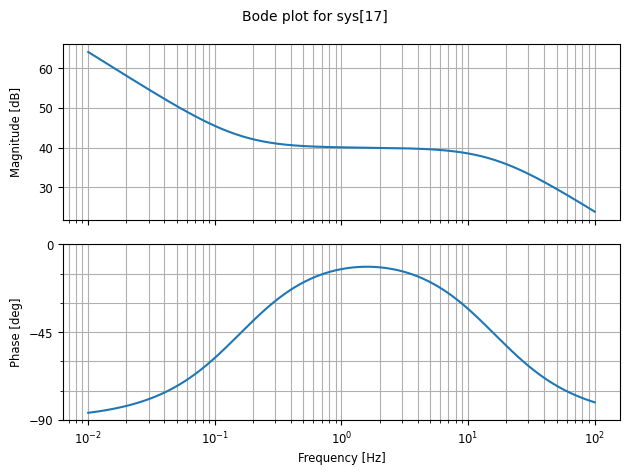

In [8]:
mag_MA, phase_MA = ct.bode(MA, Hz=True)

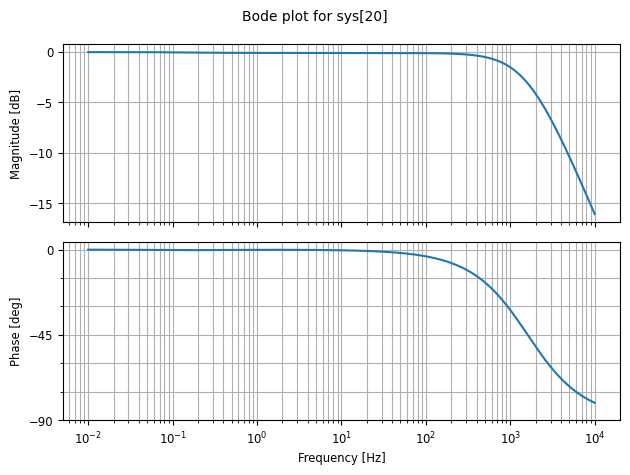

In [9]:
mag_MF, phase_MF = ct.bode(MF, Hz=True)

A resposta ao degrau do sistema pode ser obtida com a função 'step'. Diferentemente do bode, é necessário plotar separadamente os resultados.

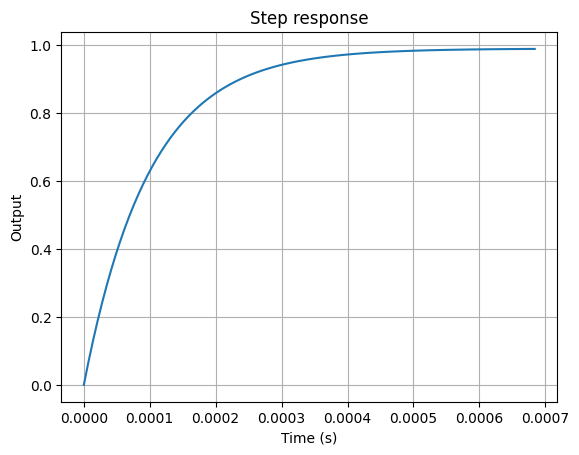

In [10]:
response, time = step(MF)

# Plot
fig, ax = plt.subplots()
ax.plot(time, response)
ax.set(title='Step response', xlabel='Time (s)', ylabel='Output')
ax.grid()


### Manipulação simbólica

Em sistemas complexos, que exigem diversas manipulações algébricas entre muitas funções de transferência, erros numéricos podem surgir e se propagar de forma que o resultado final não seja confiável.

Nesses casos, é recomendado que toda a manipulação algébrica seja feita de maneira simbólica, sem que os valores numéricos sejam inseridos a priori em cada uma das funções de transferência.

Somente após a obtenção da função de transferência final os valores numéricos são substituídos.

Este procedimento será exemplificado abaixo utilizando o mesmo sistema acima.

Primeiramente, defina todas as variáveis do sistema de maneira simbólica utilizado a biblioteca [Sympy](https://scipy-lectures.org/packages/sympy.html):

In [11]:
k_0_sym = sym.Symbol('k_0_sym')
tau_sym = sym.Symbol('tau_sym')
K_sym = sym.Symbol('K_sym')
Ti_sym = sym.Symbol('Ti_sym')

Em seguida, construa as funções de transferência utilizando a função TransferFunction da biblioteca sympy.physics.control.lti:

In [12]:
from sympy.abc import s
from sympy.physics.control.lti import TransferFunction

In [13]:
H_sym = TransferFunction(k_0_sym/(1+tau_sym*s), 1, s)
PI_sym = TransferFunction(K_sym*(1+1/Ti_sym/s), 1, s)
MA_sym = H_sym*PI_sym
unit = TransferFunction(1, 1, s)
MF_sym = unit/(unit+MA_sym) # Também pode ser substituída pela função de feedback da sympy.physics.control

print(H_sym)
print(PI_sym)
print(MA_sym)
display(MF_sym)

H_sym = H_sym.doit()
PI_sym = PI_sym.doit()
MA_sym = MA_sym.doit()
MF_sym = MF_sym.doit()

print(H_sym)
print(PI_sym)
print(MA_sym)
display(MF_sym)

TransferFunction(k_0_sym/(s*tau_sym + 1), 1, s)
TransferFunction(K_sym*(1 + 1/(Ti_sym*s)), 1, s)
Series(TransferFunction(k_0_sym/(s*tau_sym + 1), 1, s), TransferFunction(K_sym*(1 + 1/(Ti_sym*s)), 1, s))


Feedback(TransferFunction(1, 1, s), Series(TransferFunction(k_0_sym/(s*tau_sym + 1), 1, s), TransferFunction(K_sym*(1 + 1/(Ti_sym*s)), 1, s)), -1)

TransferFunction(k_0_sym/(s*tau_sym + 1), 1, s)
TransferFunction(K_sym*(1 + 1/(Ti_sym*s)), 1, s)
TransferFunction(K_sym*k_0_sym*(1 + 1/(Ti_sym*s))/(s*tau_sym + 1), 1, s)


TransferFunction(Ti_sym*s*(s*tau_sym + 1), K_sym*k_0_sym*(Ti_sym*s + 1) + Ti_sym*s*(s*tau_sym + 1), s)

Uma vez obtidas as funções de transferência finais, as variáveis simbólicas devem ser substituídas por seus valores numéricos:

In [14]:
k_0 = 100
tau = 0.01
K = 1
Ti = 1

MA = MA_sym.subs([(k_0_sym, k_0), (K_sym, K), (Ti_sym, Ti), (tau_sym, tau)])
MF = MF_sym.subs([(k_0_sym, k_0), (K_sym, K), (Ti_sym, Ti), (tau_sym, tau)])

print(MA)
display(MF)

TransferFunction(100*(1 + 1/s)/(0.01*s + 1), 1, s)


TransferFunction(s*(0.01*s + 1), s*(0.01*s + 1) + 100*s + 100, s)

Como as operações foram feitas com base na biblioteca sympy.physics.control.lti, deve-se usar as funções de plot e afins contidas na biblioteca [sympy.physics.control.control_plots](https://docs.sympy.org/latest/modules/physics/control/control_plots.html):

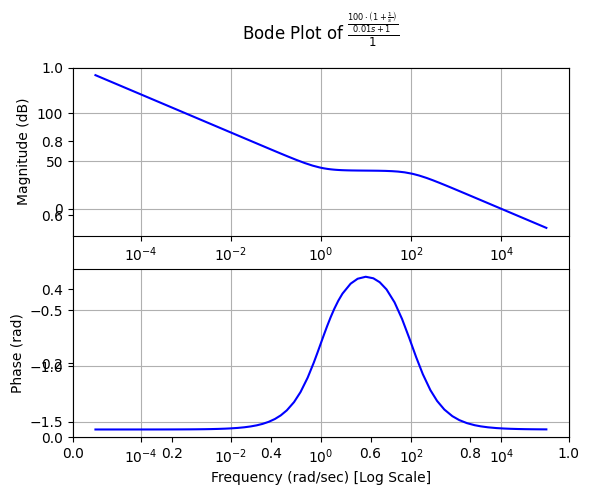

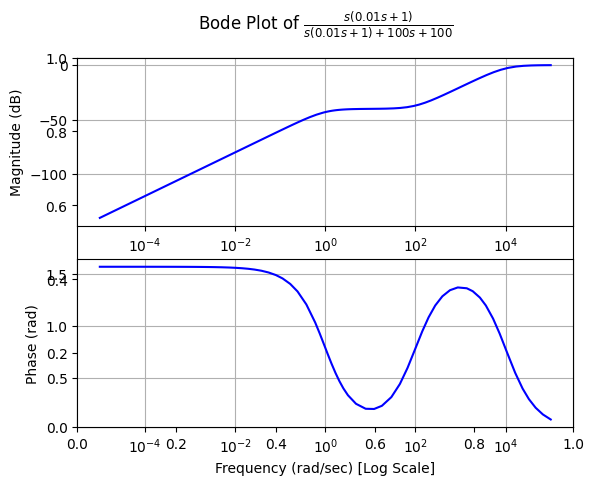

In [15]:
fig, ax = plt.subplots()
bode_plot(MA)

fig, ax = plt.subplots()
bode_plot(MF)

Dessa forma, evita-se a propagação de erros numéricos.